# 🧠 Iowa Gambling Task Behavioral Analysis

This notebook presents a behavioral analysis of the **Iowa Gambling Task (IGT)** using publicly available data from the [Open Science Framework (OSF)](https://osf.io/5pfey). The IGT is a widely used psychological task designed to simulate real-life decision-making under uncertainty and risk. Participants repeatedly choose from four card decks (A–D), each associated with varying patterns of reward and punishment.

I focused on the **100-trial version** of the task and perform a series of analyses to understand how decision behavior evolves over time. This includes:

- Loading and visualizing deck choice behavior
- Tracking shifts in advantageous vs. disadvantageous decisions
- Computing net scores to assess learning
- Summarizing the reward/loss profile for each deck

# 📥 Load Iowa Gambling Task Data from OSF

This section loads behavioral data from the Iowa Gambling Task (IGT), specifically the 100-trial version, hosted on the Open Science Framework (OSF). The dataset is contained in a ZIP archive and includes:

- `choice_100.csv`: Each subject's sequence of choices across 100 trials (values: 1–4 for deck selection).
- `wi_100.csv`: Win amounts associated with each choice.
- `lo_100.csv`: Loss amounts associated with each choice.

## ️ Steps:
1. Download the ZIP archive from the OSF URL.
2. Extract the relevant CSV files.
3. Load each file into a pandas DataFrame.

In [63]:
import requests
import zipfile
import io
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the URL for the ZIP archive containing the data
zip_url = 'https://osf.io/download/5pfey/'

# Send a GET request to download the ZIP file from OSF
response = requests.get(zip_url)

# Check if the request was successful (status code 200 = OK)
if response.status_code != 200:
    raise Exception(f"Failed to download ZIP file: {response.status_code}")

# Specify which CSV files we want to extract and load
target_files = ['choice_100.csv', 'wi_100.csv', 'lo_100.csv']
dataframes = {}

# Open the downloaded ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    for name in z.namelist():
        base = os.path.basename(name)
        if base in target_files:
            with z.open(name) as f:
                try:
                    # Read CSV file into a DataFrame (first column as index)
                    df = pd.read_csv(f, index_col=0)
                    if base == 'choice_100.csv':
                        df = df.astype(int)
                    # Store the DataFrame in a dictionary
                    dataframes[base] = df
                except Exception as e:
                    print(f"Failed to load {base}: {e}")

# Assign loaded DataFrames to individual variables for easier access
choice = dataframes.get('choice_100.csv')  # Deck choices
reward = dataframes.get('wi_100.csv')      # Win amounts
loss = dataframes.get('lo_100.csv')        # Loss amounts

# 📈 Visualizing Deck Preference Over Time

This section analyzes how subjects' preferences for each deck (A–D) evolve over the course of the Iowa Gambling Task. The 100 trials are divided into 5 equal blocks (20 trials per block), allowing us to assess changes in choice behavior over time.

Participants are expected to learn over time which decks are advantageous. By calculating the **average proportion of choices** for each deck in each block, we can observe trends that indicate learning or persistent bias.

## What This Does:
- Splits the 100 trials into 5 blocks.
- Calculates the average proportion of choices for each deck within each block.
- Visualizes these proportions over time using line plots for each deck.

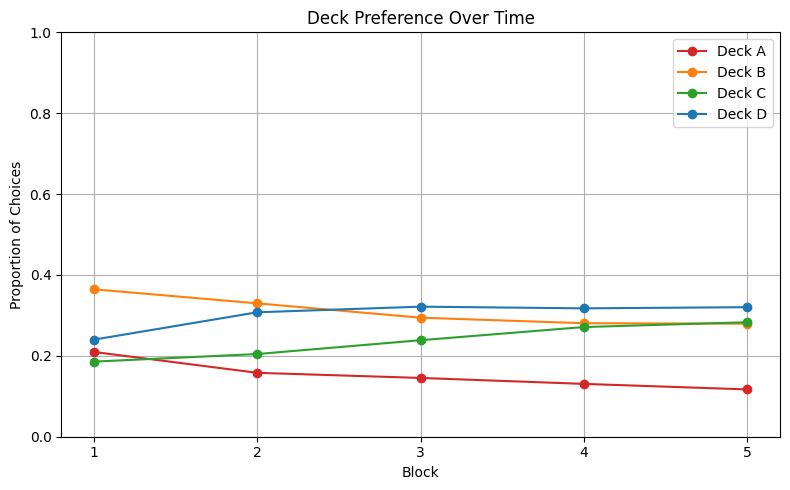

In [64]:
# Define the block structure for dividing trials into time bins
n_subjects, n_trials = choice.shape
n_blocks = 5
block_size = n_trials // n_blocks

# Map deck names (A–D) to numerical codes (1–4) used in the dataset
deck_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

# Define consistent colors for each deck for plotting
colors = {'A': 'tab:red', 'B': 'tab:orange', 'C': 'tab:green', 'D': 'tab:blue'}

# Initialize a dictionary to store average choice proportions for each deck
deck_props = {deck: [] for deck in deck_map}

# Loop over each block to compute average choice proportions
for b in range(n_blocks):
    start, end = b * block_size, (b + 1) * block_size
    block = choice.iloc[:, start:end]  # Extract block of trials

    for deck_name, deck_num in deck_map.items():
        # Count how many times each subject chose this deck in the current block
        deck_counts = (block == deck_num).sum(axis=1)

        # Compute average proportion of choices for this deck in the block
        deck_prop = deck_counts.mean() / block_size
        deck_props[deck_name].append(deck_prop)

# Plot the average proportion of choices for each deck over blocks
plt.figure(figsize=(8, 5))
for deck in deck_map:
    plt.plot(range(1, n_blocks + 1), deck_props[deck],
             marker='o', label=f"Deck {deck}", color=colors[deck])

plt.xlabel("Block")
plt.ylabel("Proportion of Choices")
plt.title("Deck Preference Over Time")
plt.xticks(range(1, n_blocks + 1))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Decks C and D (green and blue) show an increasing trend in selection over time. These are the advantageous decks, associated with smaller immediate rewards but lower long-term losses. Decks A and B (red and orange), in contrast, show a decreasing trend. These are disadvantageous decks with larger immediate rewards but larger losses.

This behavioral shift suggests that, over time, participants learned to favor advantageous decks, aligning with normative decision-making expected in the Iowa Gambling Task.

# 📐 Net Score Per Block

This section computes and visualizes the **net score** across each block of the Iowa Gambling Task. The net score is a behavioral index commonly used to quantify advantageous versus disadvantageous decision-making.

## Definition:
**Net Score = (C + D) – (A + B)**
Where:
- Decks C and D are considered **advantageous** (smaller immediate rewards, lower long-term loss).
- Decks A and B are **disadvantageous** (larger immediate rewards, but higher long-term penalties).

## Purpose:
By calculating the **mean net score per block**, we can track whether participants increasingly shift toward more advantageous choices as the task progresses,  a sign of learning and adaptive behavior. A rising net score over blocks typically indicates improved decision-making.


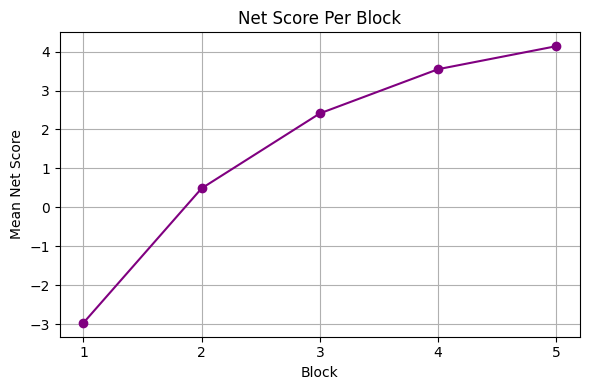

In [65]:
net_scores = []

# Loop over each block of trials
for b in range(n_blocks):
    start, end = b * block_size, (b + 1) * block_size
    block = choice.iloc[:, start:end]  # Extract trials in the current block

    # Count selections of advantageous decks (C = 3, D = 4)
    advantaged = (block == 3).astype(int).sum(axis=1) + (block == 4).astype(int).sum(axis=1)

    # Count selections of disadvantageous decks (A = 1, B = 2)
    disadvantaged = (block == 1).astype(int).sum(axis=1) + (block == 2).astype(int).sum(axis=1)

    # Compute net score for each subject, then average across all subjects
    net_score = advantaged - disadvantaged
    net_scores.append(net_score.mean())

# Plot the average net score across blocks
plt.figure(figsize=(6, 4))
plt.plot(range(1, n_blocks + 1), net_scores, marker='o', color='purple')
plt.xlabel("Block")
plt.ylabel("Mean Net Score")
plt.title("Net Score Per Block")
plt.xticks(range(1, n_blocks + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Participants started with a negative net score, reflecting early preference for high-reward, high-loss decks (A and B). The net score increases steadily across blocks, indicating a learning effect as participants shift toward more advantageous choices. This is a classic behavioral marker of successful adaptation and learning.

# 📊 Average Reward and Loss per Deck

This section summarizes the overall payoff structure of the Iowa Gambling Task by computing the **average reward** and **average loss** associated with each deck across all trials and all subjects.

## Procedure:
1. **Flatten** the matrices for choices, wins, and losses so each row represents a single trial.
2. **Combine** these into a single DataFrame for easy manipulation.
3. **Group by deck** and compute the mean reward and loss for each deck.
4. **Relabel** the deck indices from numeric (1–4) to their corresponding letters (A–D).

## Purpose:
Understanding the average reward/loss profile of each deck helps interpret behavioral patterns and validate model assumptions. It also confirms that decks C and D are indeed advantageous and that A and B are disadvantageous, based on net outcomes.

In [66]:
# Convert each matrix to a 1D array where each element is a single trial choice, reward, or loss
flat_choice = choice.values.flatten()
flat_reward = reward.values.flatten()
flat_loss = loss.values.flatten()

# Combine into a single DataFrame with trial-level structure
df_all = pd.DataFrame({
    'deck': flat_choice,     # Deck number (1=A, 2=B, 3=C, 4=D)
    'reward': flat_reward,   # Reward on that trial
    'loss': flat_loss        # Loss on that trial
})

# Group by deck and compute the average reward and loss
deck_stats = df_all.groupby('deck').mean()

# Rename the numeric deck indices to deck letters for clarity
deck_stats.index = ['A', 'B', 'C', 'D']

# Display the resulting summary table
print("Average Reward and Loss per Deck:")
print(deck_stats)

Average Reward and Loss per Deck:
       reward        loss
A  102.136429 -133.350724
B  103.926215 -143.982579
C   51.861323  -25.387776
D   53.014875  -25.738827


Decks A and B offer higher average rewards but are offset by substantially greater losses, making them net disadvantageous. Decks C and D provide lower rewards but have minimal losses, making them net advantageous.

The reward-loss asymmetry across decks confirms the expected payoff structure of the IGT and provides context for the shifting deck preferences over time.